In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

import json
from IPython.display import display, HTML
from IPython.display import Javascript

display(HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.5.0/chart.min.js" integrity="sha512-asxKqQghC1oBShyhiBwA+YgotaSYKxGP1rcSYTDrB0U6DxwlJjU59B67U8+5/++uFjcuVM8Hh5cokLjZlhm3Vg==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
'''))

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    __R = 100@u_kΩ;
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        self.__R = R
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )
        
    def wiper(self, w) :
        self.R1.resistance = self.__R * w
        self.R2.resistance = self.__R * (1.0-w)
        

# *about*

A state variable filter is constructed with two integrator amplifier and a summer. The integrators are low bass filters. The output of both is mixed back to the input. This will give three resonses. A High pass, band pass and low pass response. 

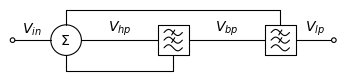

In [3]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.1)

#first muliplication
d += (elm.Dot(open=True))
d += (elm.Line().length(d.unit/2).label('$V_{in}$'))
d += ( sum := dsp.SumSigma())
d += (elm.Line().label('$V_{hp}$'))
d += (bp := dsp.Filter(response='lp'))
d += (elm.Line().label('$V_{bp}$'))
d += (lp := dsp.Filter(response='lp'))
d += (elm.Line().label('$V_{lp}$').length(d.unit/2))
d += elm.Dot(open=True)

d += elm.Line().up().at(lp.N).length(0.5)
d += elm.Line().left().tox(sum.N)
d += elm.Line().down().toy(sum.N)

d += elm.Line().down().at(bp.S).length(0.5)
d += elm.Line().left().tox(sum.S)
d += elm.Line().up().toy(sum.S)

d.draw()

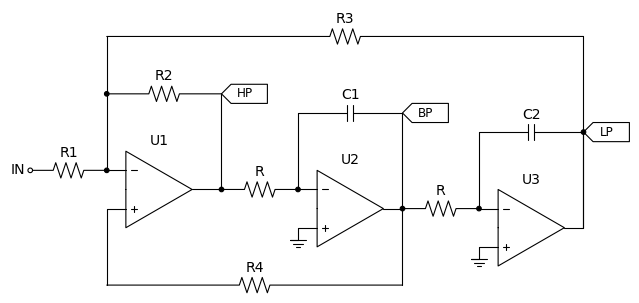

In [4]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.1)

#first muliplication
d += ( U1 := elm.Opamp().at([0,0]).label('U1'))

#the input
d += ( LUI1 := elm.Line().left().at(U1.in1).length(d.unit/4) )
d += elm.Dot()
d.push()
d += elm.Resistor().label('R1')
d += elm.Dot(open=True).label('IN', loc='lft')

d.pop()
d += ( LF1 := elm.Line().up() )
d += elm.Dot()
d += elm.Resistor().right().length(d.unit*1.5).label('R2')
d.push()
d += elm.Tag().label('HP')
d.pop()
d += elm.Line().down().toy(U1.out)
d += elm.Dot()
d.push()
d += elm.Line().left().tox(U1.out)

d.pop()
d += elm.Resistor().right().label('R')
d += elm.Dot()
d.push()
d += elm.Line().length(d.unit/4)
d += ( U2 := elm.Opamp().anchor('in1').label('U2'))

d += ( LUO1 := elm.Line().at(U2.out).right().length(d.unit/4) )
d += elm.Dot()
d += elm.Resistor().label('R')
d += elm.Dot()
d.push()
d += elm.Line().length(d.unit/4)
d += ( U3 := elm.Opamp().anchor('in1').label('U3'))
d += ( LUO2 := elm.Line().at(U3.out).right().length(d.unit/4) )

#feedback loop of second integrator
d.pop()
d += elm.Line().up()
d += elm.Capacitor().right().tox(LUO2.end).label('C2')
d += elm.Dot()
d.push()
d += elm.Tag().label('LP')
d.pop()
d += elm.Line().down().toy(LUO2.end)

#feedback loop of first integrator
d.pop()
d += ( LF2 := elm.Line().up() )
d += elm.Capacitor().right().tox(LUO1.end).label('C1')
d.push()
d += elm.Tag().label('BP')
d.pop()
d += elm.Line().down().toy(LUO1.end)

#connect the non inverting inputs to gnd
d += elm.Line().length(d.unit/4).left().at(U2.in2)
d += elm.Ground()
d += elm.Line().length(d.unit/4).left().at(U3.in2)
d += elm.Ground()

d += elm.Line().up().at(LUO2.end).length(d.unit*2.5)
d += elm.Resistor().left().tox(LF1.end).label('R3')
d += elm.Line().down().toy(LF1.end)

d += elm.Line().down().at(LUO1.end)
d += elm.Resistor().left().tox(LUI1.end).label('R4')
d += elm.Line().up().toy(U1.in2)
d += elm.Line().right().tox(U1.in2)

d.draw()

In [5]:
circuit = Circuit('svf')
circuit.include(spice_library['TL072'])

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('3', '-15V', circuit.gnd, 'DC -15')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('1', 'TL072', 'gate_in_1p', 'gate_in_1', '+15V','-15V', 'gate_out_1')
circuit.X('2', 'TL072', circuit.gnd, 'gate_in_2', '+15V','-15V', 'gate_out_2')
circuit.X('3', 'TL072', circuit.gnd, 'gate_in_3', '+15V','-15V', 'gate_out_3')

circuit.R(1, 'IN', 'gate_in_1', 10@u_kΩ)
R4 = circuit.R(4, 'gate_out_2', 'gate_in_1p', 10@u_kΩ)
circuit.R(2, 'gate_out_1', 'gate_in_1', 10@u_kΩ)
R3 = circuit.R(3, 'gate_out_3', 'gate_in_1', 10@u_kΩ)

R5 = circuit.R(5, 'gate_out_1', 'gate_in_2', 16@u_kΩ)
R6 = circuit.R(6, 'gate_out_2', 'gate_in_3', 16@u_kΩ)

circuit.C(1, 'gate_in_2', 'gate_out_2', 10@u_nF)
circuit.C(2, 'gate_in_3', 'gate_out_3', 10@u_nF)


################################################################
# run the simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
#simulator.options('INTERP')
analysis_ac = simulator.ac(start_frequency=100@u_Hz, stop_frequency=0.02@u_MHz, number_of_points=10,  variation='dec')
#analysis  = simulator.transient(step_time=20@u_us, start_time=10@u_ms, end_time=12@u_ms)

################################################################
# draw signals
#fig_buffer, ax1_buffer = plt.subplots()

#ax1_buffer.set_xlabel('time [ms]')
#ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(u_ms(analysis['IN'].abscissa), analysis['IN'], color='Grey')
#ax1_buffer.plot(u_ms(analysis['gate_out_1'].abscissa), analysis['gate_out_1'], color='Red')
#ax1_buffer.plot(u_ms(analysis['gate_out_2'].abscissa), analysis['gate_out_2'], color='Green')
#ax1_buffer.plot(u_ms(analysis['gate_out_3'].abscissa), analysis['gate_out_3'], color='Blue')

#ax1_buffer.legend(('in', 'Gate1 [V]', 'Gate2', 'Gate3 [V]'), loc=(0.75,0.8))

#plt.tight_layout()
#plt.show()


In [6]:
buffer_data = []
for r in np.arange(10000, 150000, 1000 ) :
    R5.resistance = r
    R6.resistance = r
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=100@u_Hz, stop_frequency=0.02@u_MHz, number_of_points=10,  variation='dec')

    datas = []
    datas.append(20*np.log10(np.absolute(analysis_ac.gate_out_1)).tolist())
    datas.append(20*np.log10(np.absolute(analysis_ac.gate_out_2)).tolist())
    datas.append(20*np.log10(np.absolute(analysis_ac.gate_out_3)).tolist())
    buffer_data.append(datas)

print( len(buffer_data ))

140


In [7]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="opampChart" class="chart"></canvas>
<input type="range" class="slider-width" id="opamp_resistance" name="Resistance" min="0" max="140" value="0" step="1"></input>
<p class="content">Figure 2: Simulation of a state variable filter with opamps.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var opamp_datas = %s;

const opamp_data = {
  labels: %s,
    datasets: [
    {
      label: 'HP',
      data: opamp_datas[0][0],
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'BP',
      data: opamp_datas[0][1],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'LP',
      data: opamp_datas[0][2],
      fill: false,
      borderColor: 'rgb(99, 255, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var opamp_ctx = document.getElementById('opampChart').getContext('2d');
var opampChart = new Chart(opamp_ctx, {
    type: 'line',
    data: opamp_data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                type: 'logarithmic',
                title: {
                    display: true,
                    text: 'frequency'
                } /*,
                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } */
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -10,
                max: 2,
                ticks: {
                    stepSize: 1
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let opamp_resistance = document.getElementById('opamp_resistance');
opamp_resistance.addEventListener('input', function (e) {
    opampChart.data.datasets[0].data = opamp_datas[opamp_resistance.value][0];
    opampChart.data.datasets[1].data = opamp_datas[opamp_resistance.value][1];
    opampChart.data.datasets[2].data = opamp_datas[opamp_resistance.value][2];
    opampChart.update();

});

''' % (json.dumps(buffer_data), analysis_ac.frequency.tolist() ) ))

<IPython.core.display.Javascript object>

# integrator


1591.5494309189535


/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:46: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, phase, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/site-packages/PySpice/Plot/BodeDiagram.py:36: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axe.semilogx(frequency, gain, basex=10, **kwargs)
/opt/conda/envs/elektrophon/lib/python3.9/

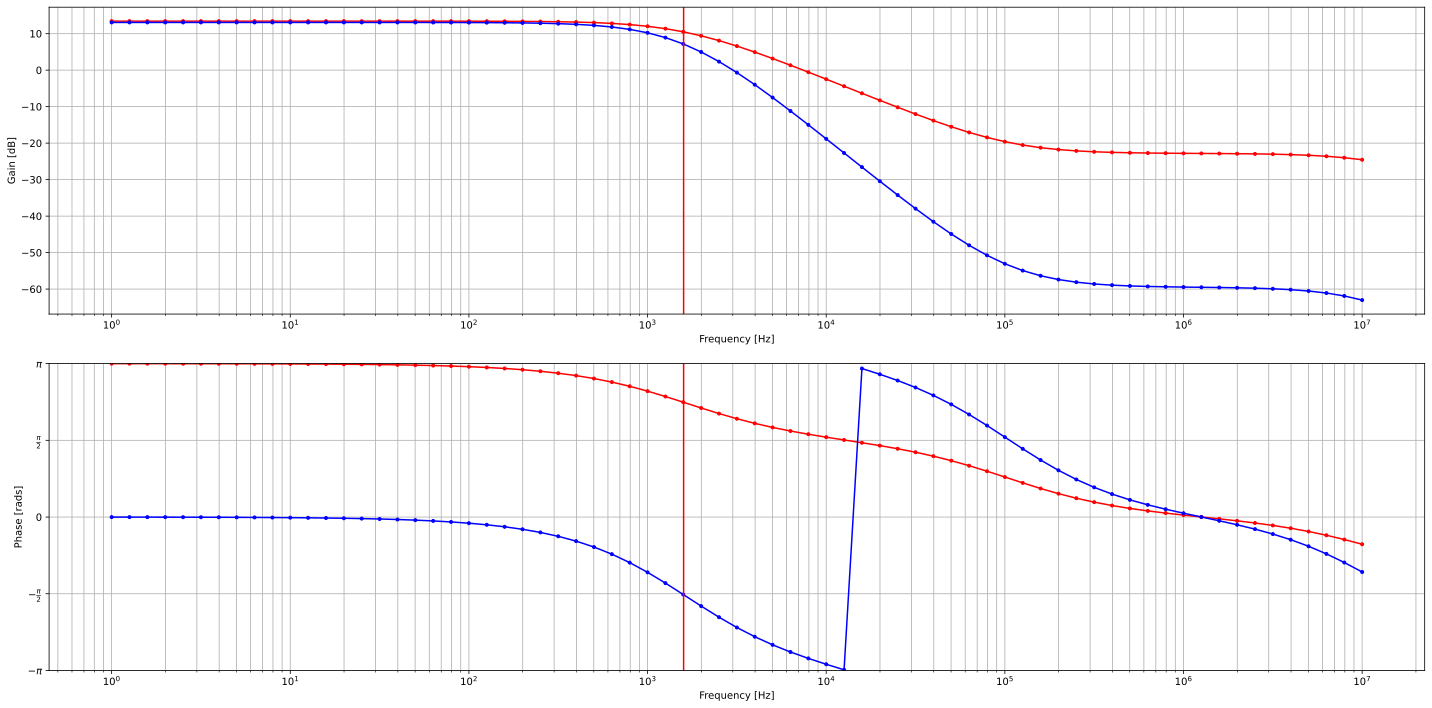

In [8]:
circuit = Circuit('svf')
circuit.include(spice_library['4069UB'])

res = 10@u_kΩ
cap = 10@u_nF

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('0', '4069UB', 'gate_in_0', 'gate_out_0', '+15V', circuit.gnd)
circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+15V', circuit.gnd)
R1 = circuit.R(1, 'IN', 'gate_in_0', res)
C1 = circuit.C(1, 'gate_out_0', 'gate_in_0', cap)
R2 = circuit.R(2, 'gate_out_0', 'gate_in_1', res)
C2 = circuit.C(2, 'gate_out_1', 'gate_in_1', cap)
circuit.R(3, 'gate_out_0', 'gate_in_0', res)
circuit.R(4, 'gate_out_1', 'gate_in_1', res)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_MHz, number_of_points=10,  variation='dec')

break_frequency = 1 / (2 * np.pi * R1.resistance * C1.capacitance )
print( break_frequency )

################################################################
# draw bode diagram
from PySpice.Plot.BodeDiagram import bode_diagram
figure = plt.figure(1, (20, 10))
plt.title("Bode Diagram of a Low-Pass RC Filter")
axes = (plt.subplot(211), plt.subplot(212))
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_0)),
             phase=np.angle(analysis_ac.gate_out_0, deg=False),
             marker='.',
             color='red',
             linestyle='-',
         )
bode_diagram(axes=axes,
             frequency=analysis_ac.frequency,
             gain=20*np.log10(np.absolute(analysis_ac.gate_out_1)),
             phase=np.angle(analysis_ac.gate_out_1, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
         )

for axe in axes:
    axe.axvline(x=break_frequency, color='red')

plt.tight_layout()
plt.show()


# cmos svf


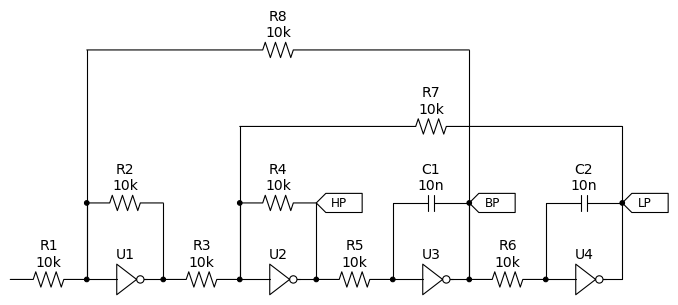

In [9]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.1)

#first muliplication
d += ( elm.Resistor().label('R1\n10k') )
d += ( D1 := elm.Dot() )
d += ( U1 := logic.Not().label('U1') )
d += ( D2 := elm.Dot() )
d += ( elm.Resistor().label('R3\n10k') )

d += ( D3 := elm.Dot() )
d += ( U2 := logic.Not().label('U2') )
d += ( D4 := elm.Dot() )
d += ( elm.Resistor().label('R5\n10k') )

d += ( D5 := elm.Dot() )
d += ( U3 := logic.Not().label('U3') )
d += ( D6 := elm.Dot() )
d += ( elm.Resistor().label('R6\n10k') )

d += ( D7 := elm.Dot() )
d += ( U4 := logic.Not().label('U4') )
#d += ( D8 := elm.Dot() )
#d += ( elm.Line().length(d.unit/2 )

d += elm.Line().up().at(D1.end)
d += elm.Dot()
d += elm.Resistor().right().label('R2\n10k')
d += elm.Line().down()

d += elm.Line().up().at(D3.end)
d += elm.Dot()
d += ( R4 := elm.Resistor().right().label('R4\n10k') )
d += elm.Line().down()

d += elm.Line().up().at(D5.end)
d += ( C1 := elm.Capacitor().right().label('C1\n10n') )
d += elm.Dot()
d += elm.Line().down()

d += elm.Line().up().at(D7.end)
d += elm.Capacitor().right().label('C2\n10n')
d += ( D8 := elm.Dot() )
d += elm.Line().down()

d += elm.Line().up().at(D6.end).length(d.unit*3)
d += elm.Resistor().left().tox(D1.end).label('R8\n10k')
d += elm.Line().down().toy(D1.end)

d += elm.Line().up().at(D8.end).length(d.unit)
d += elm.Resistor().left().tox(D3.end).label('R7\n10k')
d += elm.Line().down().toy(D3.end)

d += elm.Tag().label('HP').at(R4.end).right()
d += elm.Tag().label('BP').at(C1.end).right()
d += elm.Tag().label('LP').at(D8.end).right()

d.draw()


In [10]:
circuit = Circuit('svf')
circuit.include(spice_library['4069UB'])

res = 10@u_kΩ
cap = 1@u_nF

circuit.V('1', '+15V', circuit.gnd, 'DC 15')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 5V SIN(0 5V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+15V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+15V', circuit.gnd)
circuit.X('3', '4069UB', 'gate_in_3', 'gate_out_3', '+15V', circuit.gnd)
circuit.X('4', '4069UB', 'gate_in_4', 'gate_out_4', '+15V', circuit.gnd)

circuit.R(1, 'IN', 'gate_in_1', 10@u_kΩ)
circuit.R(2, 'gate_out_1', 'gate_in_1', 10@u_kΩ)
R3 = circuit.R(3, 'gate_out_1', 'gate_in_2', 10@u_kΩ)
R4 = circuit.R(4, 'gate_out_2', 'gate_in_2', 10@u_kΩ)
R5 = circuit.R(5, 'gate_out_2', 'gate_in_3', 10@u_kΩ)
R6 = circuit.R(6, 'gate_out_3', 'gate_in_4', 10@u_kΩ)
R7 = circuit.R(7, 'gate_out_4', 'gate_in_2', 12@u_kΩ)
R8 = circuit.R(8, 'gate_out_3', 'gate_in_1', 12@u_kΩ)

C1 = circuit.C(1, 'gate_out_3', 'gate_in_3', cap)
C2 = circuit.C(2, 'gate_out_4', 'gate_in_4', cap)
R9 = circuit.R(9, 'gate_out_3', 'gate_in_3', 100@u_kΩ)
R10 = circuit.R(10, 'gate_out_4', 'gate_in_4', 100@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_ac = simulator.ac(start_frequency=100@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')

break_frequency = 1 / (2 * np.pi * R5.resistance * C1.capacitance )
print( break_frequency )

15915.494309189533


In [11]:
buffer_data = []
for r in np.arange(10000, 110000, 1000) :
    R5.resistance = r
    R6.resistance = r
    #R3.resistance = 100000 + r
    #R4.resistance = 100000 + r
    #R7.resistance = r
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_ac = simulator.ac(start_frequency=100@u_Hz, stop_frequency=1@u_MHz, number_of_points=10,  variation='dec')

    break_frequency = 1 / (2 * np.pi * R1.resistance * C1.capacitance )
    datas = []
    datas.append(20*np.log10(np.absolute(analysis_ac.gate_out_2)).tolist())
    datas.append(20*np.log10(np.absolute(analysis_ac.gate_out_3)).tolist())
    datas.append(20*np.log10(np.absolute(analysis_ac.gate_out_4)).tolist())
    buffer_data.append(datas)
    
print( len(buffer_data) )

100


In [12]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="SVFChart" class="400px"></canvas>
<input type="range" class="slider-width" id="SVFResistance" name="SVFResistance" min="0" max="99" value="0" step="1"></input>
<p class="content">Figure 3: Overdrive 250 Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var SVFDatas = %s;

const SVFData = {
  labels: %s,
    datasets: [
    {
      label: 'HP',
      data: SVFDatas[0][0],
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'BP',
      data: SVFDatas[0][1],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'LP',
      data: SVFDatas[0][2],
      fill: false,
      borderColor: 'rgb(99, 255, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var SVFCtx = document.getElementById('SVFChart').getContext('2d');
var SVFChart = new Chart(SVFCtx, {
    type: 'line',
    data: SVFData,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: false,
                    text: '[ms]'
                },
                type: 'logarithmic',
/*                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } */
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -4,
                max: 2,
                ticks: {
                    stepSize: 0.01
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

let SVFResistance = document.getElementById('SVFResistance');
SVFResistance.addEventListener('input', function (e) {
    SVFChart.data.datasets[0].data = SVFDatas[SVFResistance.value][0];
    SVFChart.data.datasets[1].data = SVFDatas[SVFResistance.value][1];
    SVFChart.data.datasets[2].data = SVFDatas[SVFResistance.value][2];
    SVFChart.update();

});

''' % (json.dumps(buffer_data), analysis_ac.frequency.tolist() ) ))

<IPython.core.display.Javascript object>

# *references*

- [ESP](https://sound-au.com/articles/state-variable.htm) State Variable Filters

- https://www.electronics-tutorials.ws/de/filtern/zustandsvariablenfilter.html
- https://electro-music.com/forum/topic-69749-50.html
- https://www.schmitzbits.de/wasp.html
- https://www.elby-designs.com/webtek/cgs/cgs30/cgs30_bpf.html
- https://hackaday.com/2015/03/25/logic-noise-filters-and-drums/
- http://aeeprojects.blogspot.com/2011/09/filters-with-cd4069.html
- https://electro-music.com/forum/phpbb-files/svf_147.jpg
- https://electro-music.com/forum/topic-69887.html